<a href="https://colab.research.google.com/github/devdastl/-EVA-8_Phase-1_Assignment-4/blob/main/step_4/EVA_assignment_4_step4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourth code version setup in building the Neural Network
## **Target**
Following are the targets for fourth code setup.
1. Improve underfitting of the model by setting Drop Out probablity to 0 i.e. we will not perform Drop Out while training in this code setup.
2. Improve accuracy/loss fluctuation by introducing step-wise learning rate decay using `StepLR()` under `torch.optim.lr_scheduler`. This is a pytorch module which takes optimizer, decay-rate and step-size to reduce the learning rate while training the model.

Learning rate decay: Learning rate helps to setup the size of step which is required to take while calculating new values for parameters using gradients. Bigger learning rate makes this process faster as optimizer will take large steps hence faster convergence but it can also overshoot the optimial values.
Hence a Learning rate decay helps, it will take larger steps in first few epoch and then reduces the learning rate so that we don't overshoot. 

## **Result**
Below are the results of fourth code setup.
1. Total number of parameters - `9,930 (<10k)`
1. Training accuracy at 15th epoch - `99.48%`
1. Testing accuracy at 15th epoch - `99.49%`
1. Training accuracy at 20th epoch - `99.45%`
1. Testing accuracy at 20th epoch - `98.49%` 

## **Analysis**
Following are the analysis of this fourth code setup:
1. Setting Drop out to 0 (no Drop out) improves model accuracy for both train and test dataset. Means Drop Out was doing excessive regularization in third code setup.
2. Only data augmentation was enough to solve our overfitting problem in code setup 2.
3. By introducing Learning rate decay Model is giving consistant accuaracy for training and testing set.

#### **We reached our objective of consistant >99.4% accuracy under 10k parameters and under 15 epochs**
- Test accuracy at 15th epoch - `99.49%`
- Consistant? - `YES` (consistantly hitting from 6th epoch onward till 20th)
- parameters - `9,930` (under 10k)

## Import Libraries

In [32]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

- first transform perform rotation based image augmentation.
- second transform convert dataset into pytorch tensor.
- third transform will normalize the image by using mean and standerd deviation of complete dataset. We can use numpy to calculate this values as shown in cell 5.

output of cell 5 after commenting `transforms.Normalize` transformation in our `trian_transform` in below cell.
```
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - "mean: tensor(0.1307)"
 - "std: tensor(0.3081)"
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])
```
As shown above it gives values 0.1307 as mean and 0.3081 as standerd deviation.

In [33]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train/Test Split
Here we are creating pytorch dataset set class for train and test set.

In [34]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## GPU and data loader setup
In below cell first we are checking if cuda devices(GPU) are available as well as we are setting up data loader for train and test set which will create batches of the set for training.

In [35]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Model architecture
Here the CNN model just uses convolution, pooling and activation. One focus while building this architecture is to keep the parameters under 10k.
Model architecture is also shown in the github README.

**NOTE :** We are setting no drop out in this architecture by setting `dropout_value=0`. Means no drop out will be performed while training and testing.

In [36]:
dropout_value = 0 # don't use drop out
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
      # First block of CNN--------------
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 11

        # Second block of CNN---------------
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9

        # Third block of CNN---------------
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        # Forth block of CNN---------------
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1x1x10 



    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool1(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x=self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model visualization
Here we are using external tool `torchsummary` to visualize our model architecture as well as the number of paramters (which are under 10k).

In [37]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,260
       BatchNorm2d-6           [-1, 14, 24, 24]              28
              ReLU-7           [-1, 14, 24, 24]               0
           Dropout-8           [-1, 14, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,016
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0


# Training and Testing

In this cell we have writtern training and testing loop which will go through each batch of loader and will perfrom a forward pass and then gradient calcuation.

In [38]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Model training
Here we will loop through epoch and call our train and test functions which we have already defined.

**NOTE :** Here we are using step-wise learning rate decay `StepLR` from `torch.optim.lr_scheduler`

In [39]:
from torch.optim.lr_scheduler import StepLR #import lr decay module
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #setup optimizer, step_size, and decay rate(gamma) for lr decay.
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step() #step which will change lr in epochs. intervel to change is set by step_size

EPOCH: 0


Loss=0.0396273098886013 Batch_id=937 Accuracy=92.37: 100%|██████████| 938/938 [00:52<00:00, 17.95it/s]



Test set: Average loss: 0.0505, Accuracy: 9853/10000 (98.53%)

EPOCH: 1


Loss=0.167909175157547 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:50<00:00, 18.54it/s]



Test set: Average loss: 0.0352, Accuracy: 9903/10000 (99.03%)

EPOCH: 2


Loss=0.06643059849739075 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:50<00:00, 18.71it/s]



Test set: Average loss: 0.0272, Accuracy: 9924/10000 (99.24%)

EPOCH: 3


Loss=0.002709540305659175 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:49<00:00, 18.76it/s]



Test set: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.04819357767701149 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:49<00:00, 18.79it/s]



Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss=0.012172728776931763 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:50<00:00, 18.52it/s]



Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.021835533902049065 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:49<00:00, 18.82it/s]



Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

EPOCH: 7


Loss=0.06546303629875183 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:50<00:00, 18.74it/s]



Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

EPOCH: 8


Loss=0.0007873842841945589 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:49<00:00, 18.86it/s]



Test set: Average loss: 0.0177, Accuracy: 9947/10000 (99.47%)

EPOCH: 9


Loss=0.013477488420903683 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:50<00:00, 18.73it/s]



Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

EPOCH: 10


Loss=0.13453073799610138 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:50<00:00, 18.75it/s]



Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Loss=0.007195655256509781 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:49<00:00, 18.84it/s]



Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.008368389680981636 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:49<00:00, 18.90it/s]



Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

EPOCH: 13


Loss=0.004195100627839565 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:50<00:00, 18.60it/s]



Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.007462228648364544 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:49<00:00, 18.80it/s]



Test set: Average loss: 0.0169, Accuracy: 9952/10000 (99.52%)

EPOCH: 15


Loss=0.004266421776264906 Batch_id=937 Accuracy=99.48: 100%|██████████| 938/938 [00:49<00:00, 18.80it/s]



Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 16


Loss=0.0033822208642959595 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:49<00:00, 18.92it/s]



Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 17


Loss=0.010770875960588455 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:50<00:00, 18.70it/s]



Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 18


Loss=0.004019977990537882 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:49<00:00, 18.89it/s]



Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 19


Loss=0.032076217234134674 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:49<00:00, 18.82it/s]



Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)



## Result visualization
Here we will visualize or plot graphs for train and test loss and accuracy with respect to the number of iteration. (1 iteration = pass from 1 batch)

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
train_loss_list = np.array([num.item() for num in train_losses ])


Text(0.5, 1.0, 'Test Accuracy')

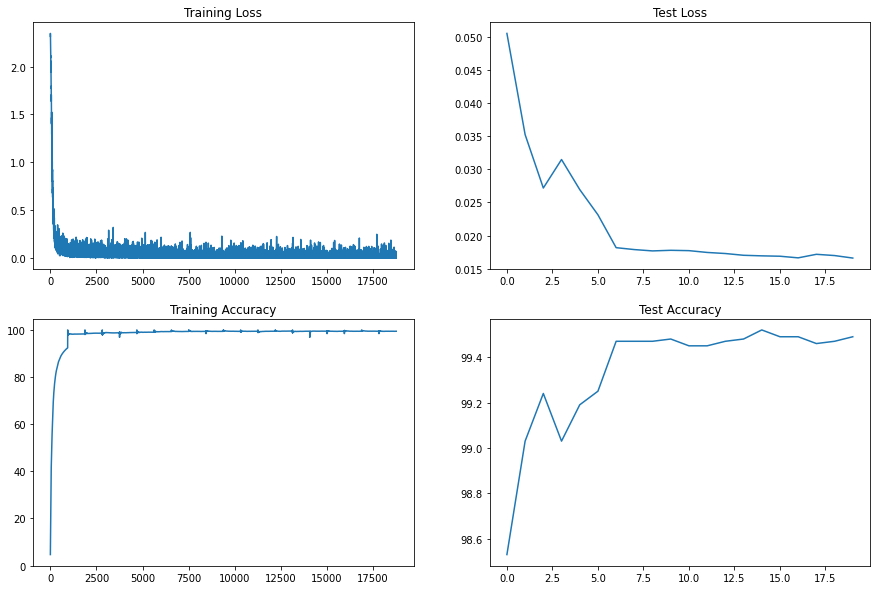

In [43]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_list)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")